# Load & Preprocess Dataset

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("diabetes.csv")

# Replace 0s with NaN for biologically implausible fields
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Fill missing values with median (simple strategy)
df.fillna(df.median(numeric_only=True), inplace=True)




In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# Feature and label split
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Feature Selection: Forward Selection

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)

# Forward Selection
sfs_forward = SequentialFeatureSelector(logreg, n_features_to_select='auto', direction='forward', scoring='accuracy', cv=5)
sfs_forward.fit(X_train_scaled, y_train)

# Selected features
selected_forward = X.columns[sfs_forward.get_support()]
print("Forward selected features:", list(selected_forward))


Forward selected features: ['Pregnancies', 'Glucose', 'BMI', 'Age']


# Feature Selection: Backward Selection

In [7]:
# Backward Selection
sfs_backward = SequentialFeatureSelector(logreg, n_features_to_select='auto', direction='backward', scoring='accuracy', cv=5)
sfs_backward.fit(X_train_scaled, y_train)

# Selected features
selected_backward = X.columns[sfs_backward.get_support()]
print("Backward selected features:", list(selected_backward))


Backward selected features: ['Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction']


# Model Training on Selected Features

Confusion Matrix:
 [[84 15]
 [21 34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82        99
           1       0.69      0.62      0.65        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154

ROC AUC Score: 0.8163452708907254


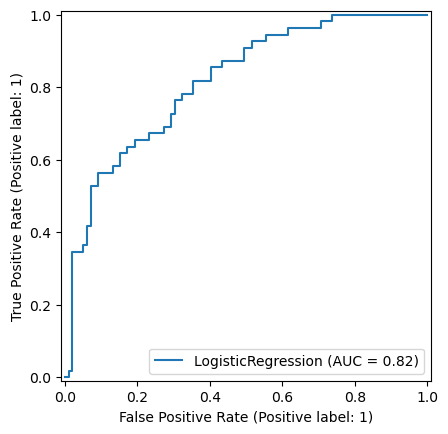

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Use forward selection features
X_train_fs = X_train[selected_forward]
X_test_fs = X_test[selected_forward]

# Scale again
X_train_fs_scaled = scaler.fit_transform(X_train_fs)
X_test_fs_scaled = scaler.transform(X_test_fs)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_fs_scaled, y_train)

# Predict
y_pred = model.predict(X_test_fs_scaled)
y_prob = model.predict_proba(X_test_fs_scaled)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test_fs_scaled, y_test)
